In [1]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings
from gr00t.experiment.data_config import DATA_CONFIG_MAP
from gr00t.model.policy import L1Gr00tPolicy
from gr00t.data.schema import EmbodimentTag
from gr00t.data.dataset import LeRobotSingleDataset
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

warnings.simplefilter("ignore", category=FutureWarning)

/home/nlp/anaconda3/envs/gr00t/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.2+cu121 with CUDA 1201 (you have 2.5.1+cu124)
    Python  3.10.13 (you have 3.10.16)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/home/nlp/.local/lib/python3.10/site-packages/xformers/triton/softmax.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16 

In [2]:
PRE_TRAINED_MODEL_PATH = "nvidia/GR00T-N1-2B"
L1_GR00T_MODEL_PATH = "./"
EMBODIMENT_TAG = EmbodimentTag.GR1
DATASET_PATH = "../../demo_data/robot_sim.PickNPlace"


data_config = DATA_CONFIG_MAP["gr1_arms_only"]
modality_config = data_config.modality_config()
modality_transform = data_config.transform()


dataset = LeRobotSingleDataset(
    dataset_path=DATASET_PATH,
    modality_configs=modality_config,
    video_backend="decord",
    video_backend_kwargs=None,
    transforms=None,  # We'll handle transforms separately through the policy
    embodiment_tag=EMBODIMENT_TAG,
)


Initialized dataset robot_sim.PickNPlace with EmbodimentTag.GR1


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pretrained dual brain from /home/nlp/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action backbone: True
Model not found or avail in the huggingface hub. Loading from local path: /home/nlp/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb
Total number of action backbone's parameters:  453206016


Some weights of L1_GR00T_N1 were not initialized from the model checkpoint at /home/nlp/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb and are newly initialized: ['action_head.action_embedding.weight', 'action_head.action_encoder.layer1.W', 'action_head.action_encoder.layer1.b', 'action_head.action_encoder.layer2.W', 'action_head.action_encoder.layer2.b', 'action_head.position_embedding.pe']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of L1_GR00T_N1 were not initialized from the model checkpoint at /home/nlp/.cache/huggingface/hub/models--nvidia--GR00T-N1-2B/snapshots/32e1fd2507f7739fad443e6b449c8188e0e02fcb and are newly initialized because the shapes did not match:
- action_head.action_decoder.layer1.W: found shape torch.Size([32, 1024, 1024]) in the checkpoint and torch.Size([32, 1536, 1024]) in the model instantiated
You should probably TRAIN this m

Tune action head projector: True
Tune action head diffusion model: True
Tune action head projector: True
Tune action head diffusion model: True
inferencing at step:  0


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.8009122887836043
Average inference time per action: 0.0052589829762776695
Average inference time per action_horizon: 0.08764971627129449


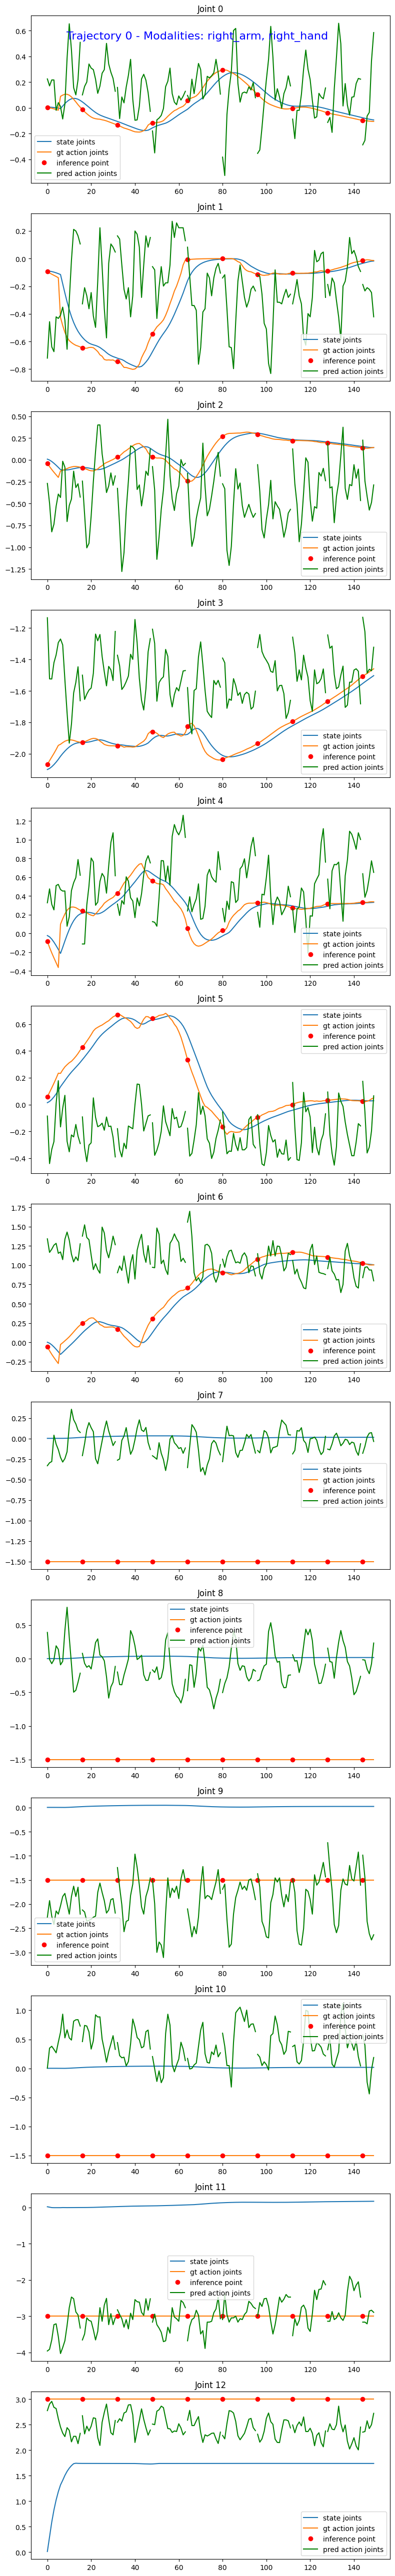

MSE loss for trajectory 0: 0.8009122887836043


In [3]:

pre_trained_policy = L1Gr00tPolicy(
    l1_model_path=L1_GR00T_MODEL_PATH,
    model_path=PRE_TRAINED_MODEL_PATH,
    embodiment_tag=EMBODIMENT_TAG,
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

mse = calc_mse_for_single_trajectory(
    pre_trained_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

In [4]:
total_trajectories = len(dataset.trajectory_lengths)

print("Total trajectories:", total_trajectories)

sampled_trajectories = np.random.choice(total_trajectories, 10)
print("Sampled trajectories:", sampled_trajectories)

all_mses = []

for traj_id in sampled_trajectories:
    mse = calc_mse_for_single_trajectory(
        pre_trained_policy,
        dataset,
        traj_id=traj_id,
        modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
        steps=150,
        action_horizon=16,
        plot=False
    )
    print(f"Trajectory {traj_id} MSE: {mse:.4f}")
    
    all_mses.append(mse)

print("====================================")
print("Mean MSE:", np.mean(all_mses))
print("Std MSE:", np.std(all_mses))


Total trajectories: 5
Sampled trajectories: [1 3 0 3 2 1 2 3 3 0]
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 0.8868003478617897
Average inference time per action: 0.0027043978373209637
Average inference time per action_horizon: 0.04507329728868273
Trajectory 1 MSE: 0.8868
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Action MSE across single traj: 1.0341580834749917
Average inference time per action: 0.003069149653116862
Average inference time per action_horizon: 0.05115249421861437
Trajectory 3 MSE: 1.0342
inferencing at 

Model not found or avail in the huggingface hub. Loading from local path: ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-500
Loading pretrained dual brain from ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-500
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action backbone: True
Model not found or avail in the huggingface hub. Loading from local path: ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-500
Total number of action backbone's parameters:  453206016
Tune action head projector: True
Tune action head diffusion model: True
Tune action head projector: True
Tune action head diffusion model: True
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Actio

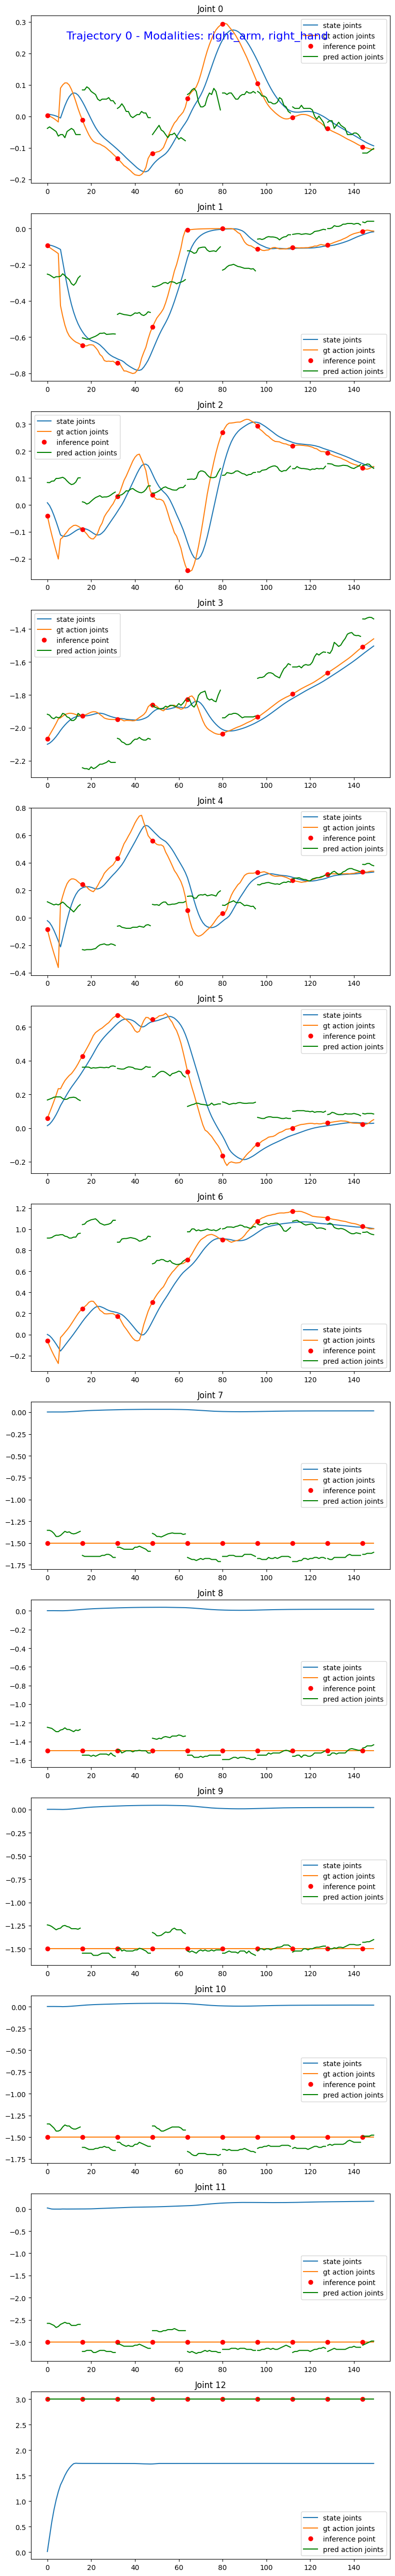

MSE loss for trajectory 0: 0.04488390065534128


In [5]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings

finetuned_model_path = "../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-500"
finetuned_policy = L1Gr00tPolicy(
    l1_model_path=finetuned_model_path,
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config,
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)

In [6]:
del finetuned_policy
del pre_trained_policy

Model not found or avail in the huggingface hub. Loading from local path: ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-2000
Loading pretrained dual brain from ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-2000
Tune backbone vision tower: True
Tune backbone LLM: False
Tune action head projector: True
Tune action backbone: True
Model not found or avail in the huggingface hub. Loading from local path: ../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-2000
Total number of action backbone's parameters:  453206016
Tune action head projector: True
Tune action head diffusion model: True
Tune action head projector: True
Tune action head diffusion model: True
inferencing at step:  0
inferencing at step:  16
inferencing at step:  32
inferencing at step:  48
inferencing at step:  64
inferencing at step:  80
inferencing at step:  96
inferencing at step:  112
inferencing at step:  128
inferencing at step:  144
Unnormalized Ac

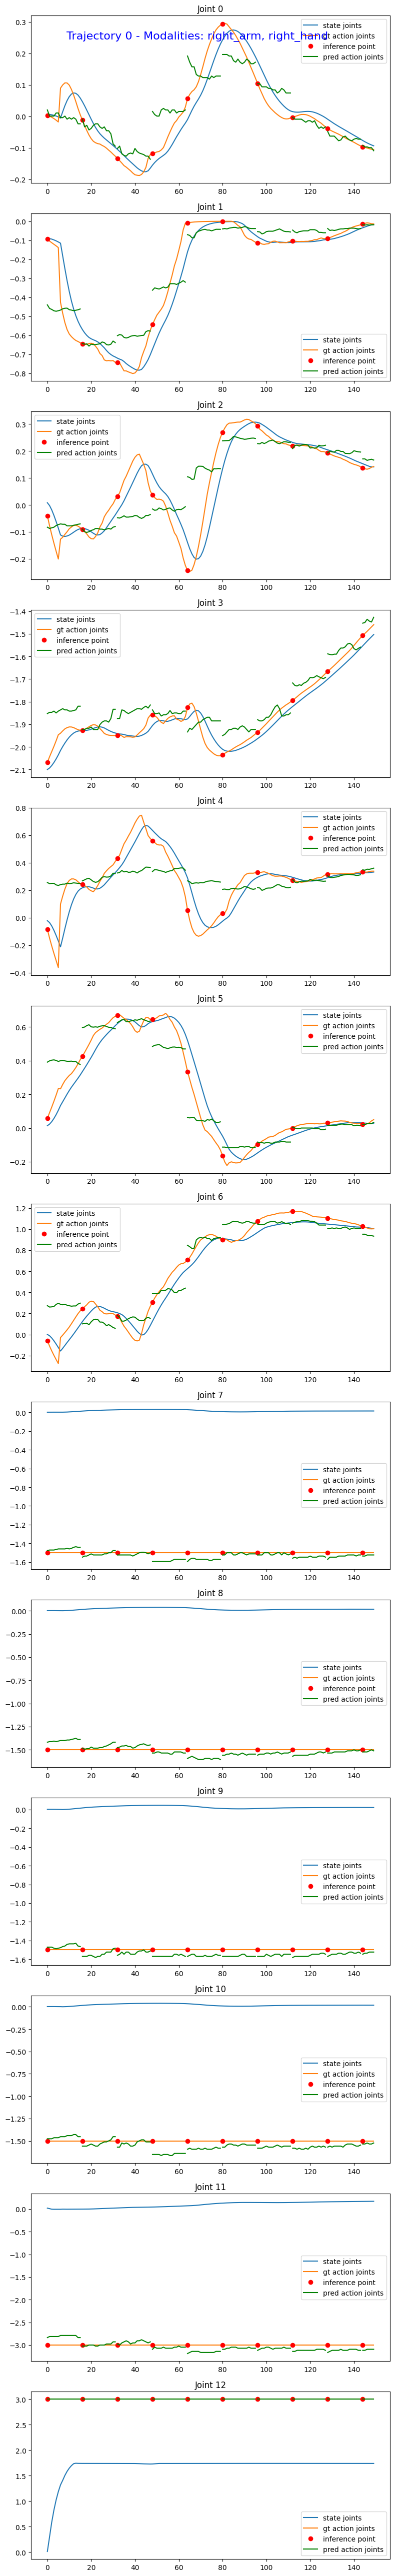

MSE loss for trajectory 0: 0.009579598393423244


In [8]:
from gr00t.utils.eval import calc_mse_for_single_trajectory
import warnings

finetuned_model_path = "../../checkpoints/l2_gr00t-with-past-actions/finetuned-model/checkpoint-2000"
finetuned_policy = L1Gr00tPolicy(
    l1_model_path=finetuned_model_path,
    model_path=finetuned_model_path,
    embodiment_tag="new_embodiment",
    modality_config=modality_config, 
    modality_transform=modality_transform,
    device=device,
)

warnings.simplefilter("ignore", category=FutureWarning)

mse = calc_mse_for_single_trajectory(
    finetuned_policy,
    dataset,
    traj_id=0,
    modality_keys=["right_arm", "right_hand"],   # we will only evaluate the right arm and right hand
    steps=150,
    action_horizon=16,
    plot=True
)

print("MSE loss for trajectory 0:", mse)